In [9]:
import numpy as np
from scipy.integrate import solve_ivp, OdeSolver
import matplotlib.pyplot as plt
from joblib import load

import os, sys
# local modules
directory_to_prepend = os.path.abspath("../../src")
if directory_to_prepend not in sys.path:
    sys.path = [directory_to_prepend] + sys.path

from utils.utils import get_median_from_experiment, get_summary
from utils.swim import backward 
from hamiltonians.lotka_volterra import LotkaVolterra
from error_functions.index import l2_error, l2_error_relative, mean_squared_error, mean_absolute_error
from utils.grid import generate_grid
from utils.plot import plot_2d, plot_ground_truth_trajectory_2d, plot_predicted_trajectories_2d, plot_predicted_trajectory_errors, plot_predicted_trajectory_energy

EXPERIMENT_DIR = '../../old_old_cluster/out/lotka_volterra_domain/random/100q_train100p_train_lotka_volterra.pkl'

# load experiment
experiment = load(EXPERIMENT_DIR)
print(f"-> LOADED EXPERIMENT: {EXPERIMENT_DIR}")
print(f"                      {experiment.keys()} ")
print(f"                      n_runs = {len(experiment['runs'])} ")
print(f"                      single run includes keys: {experiment['runs'][0].keys()}")
print(f"-> SUMMARY:\n{get_summary(experiment, ['ELM', 'U-SWIM', 'A-SWIM', 'SWIM'], ['test'], ['errors'], ['l2_error_relative'], ['median', 'mean'])}")
print(f"-> ")
print(f"-> ELM bias min: {np.min(experiment['runs'][0]['ELM'][0].biases)}, max: {np.max(experiment['runs'][0]['ELM'][0].biases)}")

domain_params = experiment['domain_params']
H = experiment['domain_params']['H']
dH = experiment['domain_params']['dH']

print(f"-> DOMAIN PARAMS: {domain_params}")
elm_params = experiment['elm_params']
uswim_params = experiment['uswim_params']
aswim_params = experiment['aswim_params']
swim_params = experiment['swim_params']

print(f"-> ELM PARAMS: {elm_params}")
print(f"-> USWIM PARAMS: {uswim_params}")
print(f"-> ASWIM PARAMS: {aswim_params}")
print(f"-> SWIM PARAMS: {swim_params}")

elm_median_error, _, _, ELM = get_median_from_experiment(EXPERIMENT_DIR, 'ELM', error_function='l2_error_relative') 
uswim_median_error, _, _, USWIM = get_median_from_experiment(EXPERIMENT_DIR, 'U-SWIM', error_function='l2_error_relative') 
aswim_median_error, _, _, ASWIM = get_median_from_experiment(EXPERIMENT_DIR, 'A-SWIM', error_function='l2_error_relative') 
swim_median_error, _, _, SWIM = get_median_from_experiment(EXPERIMENT_DIR, 'SWIM', error_function='l2_error_relative') 

print(f"-> MEDIAN ERRORS")
print(f"- ELM:    {elm_median_error}")
print(f"- U-SWIM: {uswim_median_error}")
print(f"- A-SWIM: {aswim_median_error}")
print(f"- SWIM:   {swim_median_error}")

-> LOADED EXPERIMENT: ../../old_old_cluster/out/lotka_volterra_domain/random/100q_train100p_train_lotka_volterra.pkl
                      dict_keys(['domain_params', 'elm_params', 'uswim_params', 'aswim_params', 'swim_params', 'runs']) 
                      n_runs = 100 
                      single run includes keys: dict_keys(['train_random_seed', 'test_random_seed', 'model_random_seed', 'train_errors', 'train_losses', 'test_errors', 'test_losses', 'train_times', 'ELM', 'U-SWIM', 'A-SWIM', 'SWIM'])
-> SUMMARY:
test errors median (l2_error_relative)
- ELM   	: 1.7990794619062165e-12
- U-SWIM   	: 9.236605932284805e-10
- A-SWIM   	: 7.407651533657073e-10
- SWIM   	: 4.417764884652153e-10
test errors mean (l2_error_relative)
- ELM   	: 2.5063941997073018e-11
- U-SWIM   	: 8.763598996532783e-09
- A-SWIM   	: 3.838343919161808e-09
- SWIM   	: 5.510953209657891e-09
-> 
-> ELM bias min: -5.994613425880141, max: 5.99804039234129
-> DOMAIN PARAMS: {'system_name': 'lotka_volterra', 'H': <bou

# **Ground Truth**

q_plot_range shape (100,)
p_plot_range shape (100,)
q_plot_grid shape (100, 100)
p_plot_grid shape (100, 100)


<Figure size 640x480 with 0 Axes>

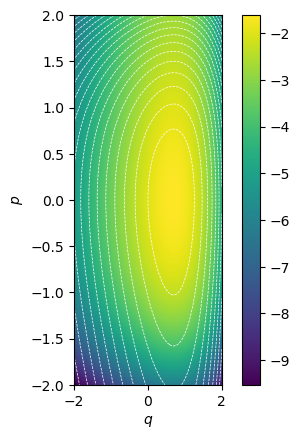


lim for q: [-2.0, 2.0]
lim for p: [-2.0, 2.0]


<Figure size 640x480 with 0 Axes>

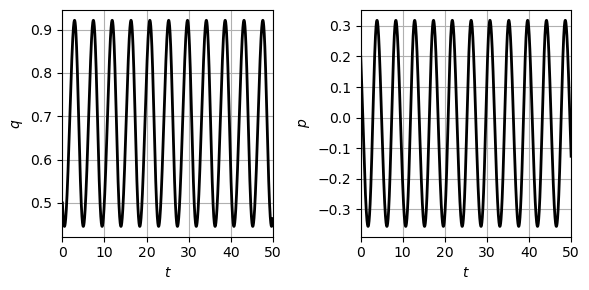

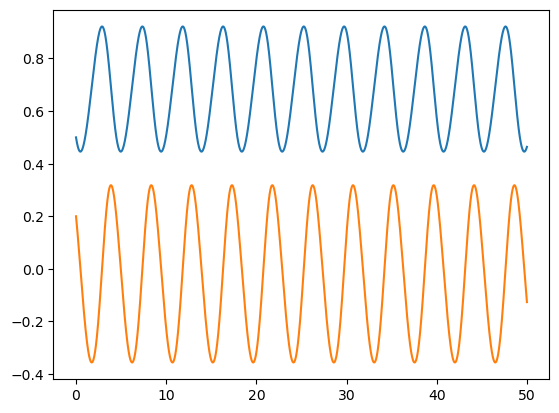

In [17]:
#domain_params['q_test_lim'] = [[-6.28, 6.28]]
#domain_params['p_test_lim'] = [[-6, 6]]

# plot the ground truth phase space, linearly spaced in the test set range
[q_plot_range], [p_plot_range], [q_plot_grid], [p_plot_grid] = generate_grid([domain_params["q_test"]], [domain_params["p_test"]], 
                                                                             [domain_params["q_test_lim"]], [domain_params["p_test_lim"]], dof=1, linspace=True)
print(f'q_plot_range shape {q_plot_range.shape}')
print(f'p_plot_range shape {p_plot_range.shape}')
print(f'q_plot_grid shape {q_plot_grid.shape}')
print(f'p_plot_grid shape {p_plot_grid.shape}')
x_plot  = np.column_stack([q_plot_grid.flatten(), p_plot_grid.flatten()]) # (N,2)
y_plot = H(x_plot).reshape((domain_params["p_test"], domain_params["q_test"])) 
plot_2d(y_plot, q_plot_range, p_plot_range, extent=domain_params["q_test_lim"] + domain_params["p_test_lim"], contourlines=20, xlabel=r'$q$', ylabel=r'$p$', 
        aspect=2.5, verbose=True, save='lotka_volterra_ground_truth_phase.pdf')

def dt_true(t, x): 
    """
    ground truth time derivatives of q and p 
    """
    x = x.reshape(1,-1)
    dH_true = dH(x).T.reshape(-1)
    #print("dH is:", str(dH))
    return [dH_true[1], -dH_true[0]] # [dH/dp, -dH/dq][q^dot, p^dot]

# RK45
t_span = [0, 50]
t_eval = np.linspace(t_span[0], t_span[1], 50000)
y0 = [0.5, 0.2]

pendulum_motion_true = solve_ivp(dt_true, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-13)
# get integrated trajectories of shape (N,2)
traj_true = pendulum_motion_true.y.T

q_train_lim_start = experiment['domain_params']['q_train_lim'][0]
q_train_lim_end = experiment['domain_params']['q_train_lim'][1]
p_train_lim_start = experiment['domain_params']['p_train_lim'][0]
p_train_lim_end = experiment['domain_params']['p_train_lim'][1]
print(f"lim for q: [{q_train_lim_start}, {q_train_lim_end}]")
print(f"lim for p: [{p_train_lim_start}, {p_train_lim_end}]")
if np.any(traj_true[:,0] < q_train_lim_start):
    print(f"WARNING: found q={np.min(traj_true[:,0])}, which is out of bounds for this experiment")
elif np.any(traj_true[:,0] > q_train_lim_end):
    print(f"WARNING: found q={np.max(traj_true[:,0])}, which is out of bounds for this experiment")
    
if np.any(traj_true[:,1] < p_train_lim_start):
    print(f"WARNING: found p={np.min(traj_true[:,1])}, which is out of bounds for this experiment")
elif np.any(traj_true[:,1] > p_train_lim_end):
    print(f"WARNING: found p={np.max(traj_true[:,1])}, which is out of bounds for this experiment")

plot_ground_truth_trajectory_2d(t_span, t_eval, traj_true, verbose=True, save='lotka_volterra_ground_truth_integration.pdf', linewidth=2)

plt.clf()
plt.plot(t_eval, traj_true[:,0])
plt.plot(t_eval, traj_true[:,1])

# **Predictions**

<Figure size 640x480 with 0 Axes>

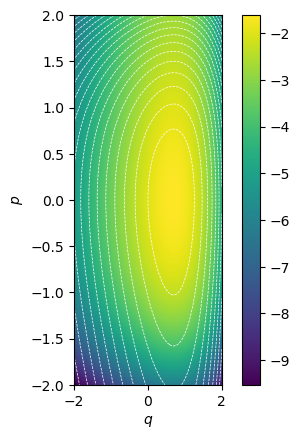

<Figure size 640x480 with 0 Axes>

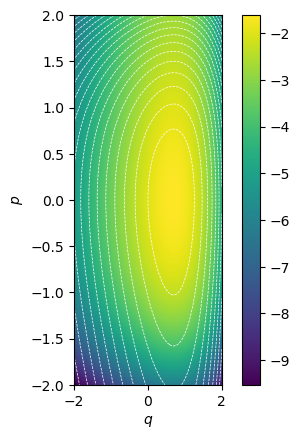

<Figure size 640x480 with 0 Axes>

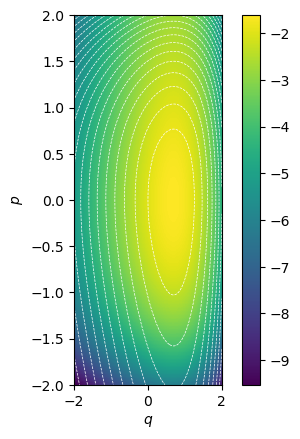

<Figure size 640x480 with 0 Axes>

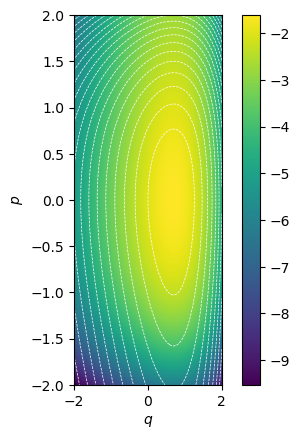


-> integrating ELM
-> integrating USWIM
-> integrating ASWIM
-> integrating SWIM


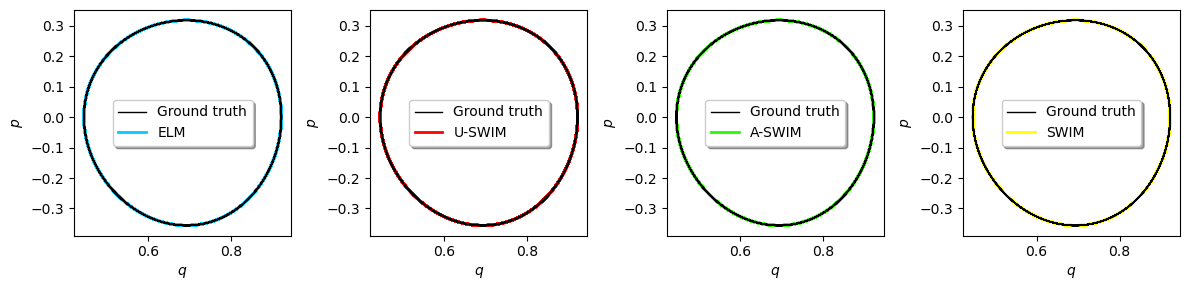

<Figure size 640x480 with 0 Axes>

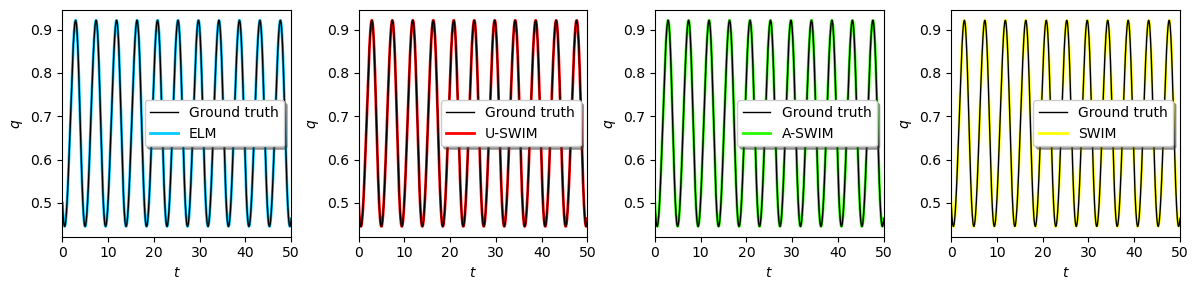

<Figure size 640x480 with 0 Axes>

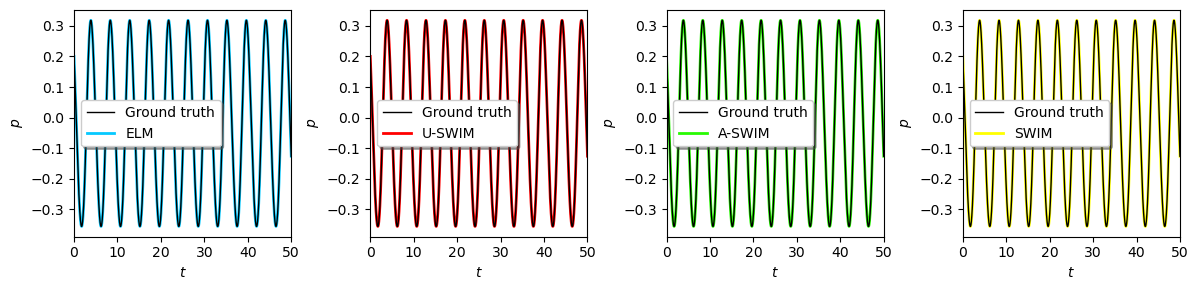

<Figure size 640x480 with 0 Axes>

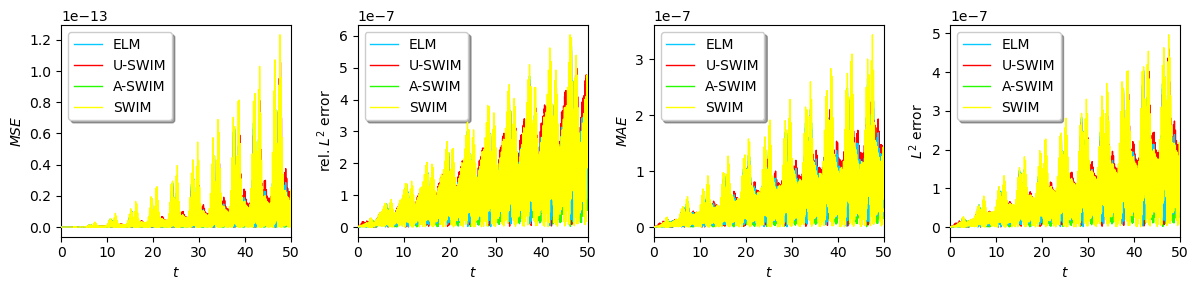

<Figure size 640x480 with 0 Axes>

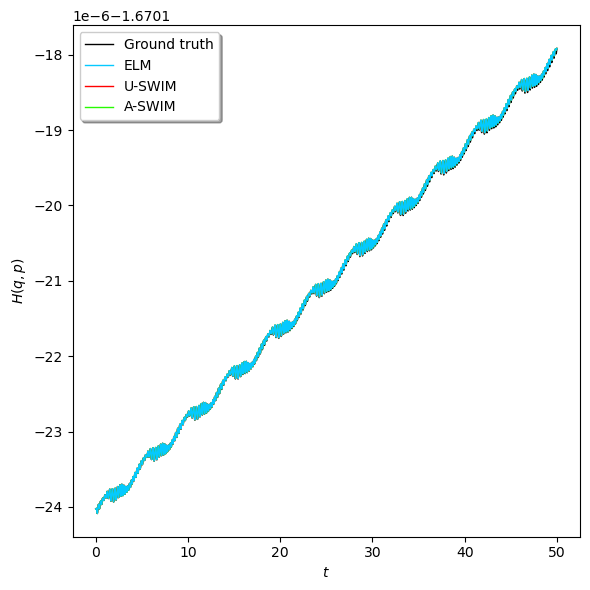

<Figure size 640x480 with 0 Axes>

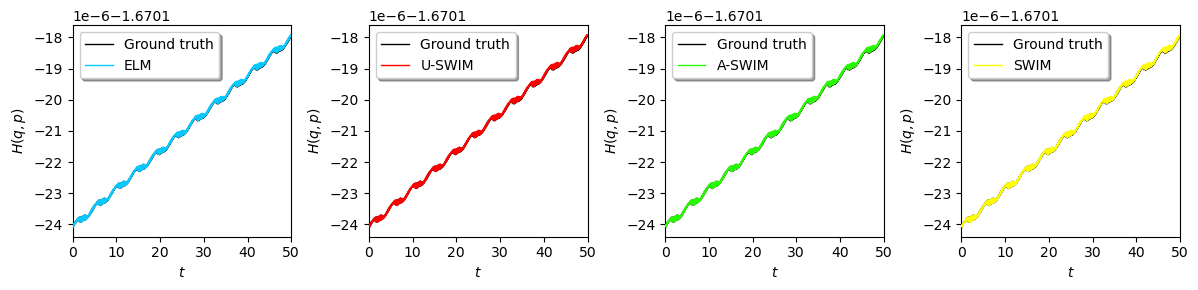

In [21]:
# phase
y_plot = ELM.transform(x_plot).reshape((domain_params["p_test"], domain_params["q_test"])) 
plot_2d(y_plot, q_plot_range, p_plot_range, extent=domain_params["q_test_lim"] + domain_params["p_test_lim"], contourlines=20, xlabel=r'$q$', ylabel=r'$p$', 
        aspect=2.5, verbose=True, save='lotka_volterra_elm_phase.pdf')
y_plot = USWIM.transform(x_plot).reshape((domain_params["p_test"], domain_params["q_test"])) 
plot_2d(y_plot, q_plot_range, p_plot_range, extent=domain_params["q_test_lim"] + domain_params["p_test_lim"], contourlines=20, xlabel=r'$q$', ylabel=r'$p$', 
        aspect=2.5, verbose=True, save='lotka_volterra_uswim_phase.pdf')
y_plot = ASWIM.transform(x_plot).reshape((domain_params["p_test"], domain_params["q_test"])) 
plot_2d(y_plot, q_plot_range, p_plot_range, extent=domain_params["q_test_lim"] + domain_params["p_test_lim"], contourlines=20, xlabel=r'$q$', ylabel=r'$p$', 
        aspect=2.5, verbose=True, save='lotka_volterra_aswim_phase.pdf')
y_plot = SWIM.transform(x_plot).reshape((domain_params["p_test"], domain_params["q_test"])) 
plot_2d(y_plot, q_plot_range, p_plot_range, extent=domain_params["q_test_lim"] + domain_params["p_test_lim"], contourlines=20, xlabel=r'$q$', ylabel=r'$p$', 
        aspect=2.5, verbose=True, save='lotka_volterra_swim_phase.pdf')

def dt_pred_elm(t, x):
    """
    ELM
    predicted time derivatives of q and p 
    """
    x = x.reshape(1,-1)
    dH_hat = backward(ELM, elm_params['activation'], x).T.reshape(-1)
    #print("dH_hat is:", str(dH_hat))
    return [dH_hat[1], -dH_hat[0]] 

def dt_pred_uswim(t, x):
    """
    U-SWIM
    predicted time derivatives of q and p
    """
    x = x.reshape(1,-1)
    dH_hat = backward(USWIM, uswim_params['activation'], x).T.reshape(-1)
    #print("dH_hat is:", str(dH_hat))
    return [dH_hat[1], -dH_hat[0]] 

def dt_pred_aswim(t, x):
    """
    A-SWIM
    predicted time derivatives of q and p
    """
    x = x.reshape(1,-1)
    dH_hat = backward(ASWIM, aswim_params['activation'], x).T.reshape(-1)
    #print("dH_hat is:", str(dH_hat))
    return [dH_hat[1], -dH_hat[0]] 

def dt_pred_swim(t,x):
    """
    SWIM
    predicted time derivatives of q and p
    """
    x = x.reshape(1,-1)
    dH_hat = backward(SWIM, aswim_params['activation'], x).T.reshape(-1)
    return [dH_hat[1], -dH_hat[0]]

print(f"-> integrating ELM")
pendulum_motion_pred_elm = solve_ivp(dt_pred_elm, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-8)
print(f"-> integrating USWIM")
pendulum_motion_pred_uswim = solve_ivp(dt_pred_uswim, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-8)
print(f"-> integrating ASWIM")
pendulum_motion_pred_aswim = solve_ivp(dt_pred_aswim, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-8)
print(f"-> integrating SWIM")
pendulum_motion_pred_swim = solve_ivp(dt_pred_swim, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-8)

# get integrated trajectories of shape (N,2)
traj_true = pendulum_motion_true.y.T
traj_pred_elm = pendulum_motion_pred_elm.y.T
traj_pred_uswim = pendulum_motion_pred_uswim.y.T
traj_pred_aswim = pendulum_motion_pred_aswim.y.T
traj_pred_swim = pendulum_motion_pred_swim.y.T

plot_predicted_trajectories_2d(t_span, t_eval, traj_true, traj_pred_elm, traj_pred_uswim, traj_pred_aswim, traj_pred_swim, 
                               zorders=[2,1,1,1,1], linewidths=[1,2,2,2,2], verbose=True, 
                               save=['lotka_volterra_predicted_integration_q_against_p.pdf', 'lotka_volterra_predicted_integration_t_against_q.pdf', 'lotka_volterra_predicted_integration_t_against_p.pdf'])



plot_predicted_trajectory_errors(t_span, t_eval, traj_true, traj_pred_elm, traj_pred_uswim, traj_pred_aswim, traj_pred_swim, 
                                zorders=[5,4,3,8], linewidths=[1,1,1,1], verbose=True, save='lotka_volterra_predicted_integration_errors.pdf')

# true energies at the predicted trajectories
energy_true = H(traj_true)
energy_elm = H(traj_pred_elm)
energy_uswim = H(traj_pred_uswim)
energy_aswim = H(traj_pred_aswim)
energy_swim = H(traj_pred_swim)

plot_predicted_trajectory_energy(t_span, t_eval, energy_true, energy_elm, energy_uswim, energy_aswim, energy_swim, 
                                 zorders=[2,14,7,8,9], linewidths=[1,1,1,1,1], verbose=True, save='lotka_volterra_integration_energies.pdf')

lim for q: [0.0, 10.0]
lim for p: [0.0, 10.0]


/home/gergedan/WS24/thesis/src/hamiltonians/lotka_volterra.py:26: RuntimeWarning: overflow encountered in power
  dq = 2 - np.e**q
/home/gergedan/.local/miniconda3/envs/thesis/lib/python3.12/site-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in divide
  return norm(self._estimate_error(K, h) / scale)


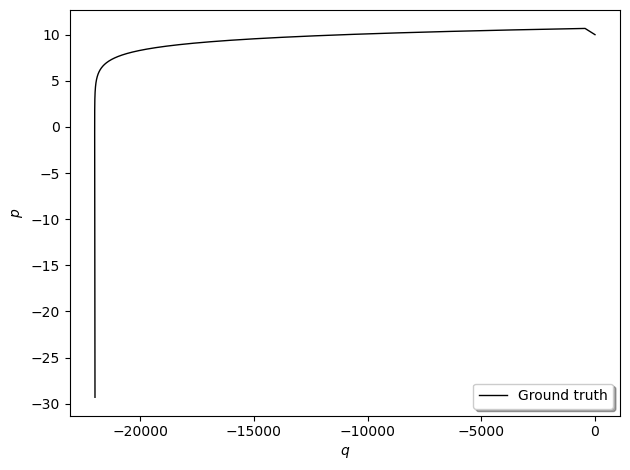

In [20]:
# RK45
t_span = [0, 20]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
y0 = [10, 10]

pendulum_motion_true = solve_ivp(dt_true, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-13)

# get integrated trajectories of shape (N,2)
traj_true = pendulum_motion_true.y.T

q_train_lim_start = experiment['domain_params']['q_train_lim'][0][0]
q_train_lim_end = experiment['domain_params']['q_train_lim'][0][1]
p_train_lim_start = experiment['domain_params']['p_train_lim'][0][0]
p_train_lim_end = experiment['domain_params']['p_train_lim'][0][1]
print(f"lim for q: [{q_train_lim_start}, {q_train_lim_end}]")
print(f"lim for p: [{p_train_lim_start}, {p_train_lim_end}]")
if np.any(traj_true[:,0] < q_train_lim_start):
    print(f"WARNING: found q={np.min(traj_true[:,0])}, which is out of bounds for this experiment")
elif np.any(traj_true[:,0] > q_train_lim_end):
    print(f"WARNING: found q={np.max(traj_true[:,0])}, which is out of bounds for this experiment")
    
if np.any(traj_true[:,0] < p_train_lim_start):
    print(f"WARNING: found p={np.min(traj_true[:,1])}, which is out of bounds for this experiment")
elif np.any(traj_true[:,0] > p_train_lim_end):
    print(f"WARNING: found p={np.max(traj_true[:,1])}, which is out of bounds for this experiment")
    
# plots colors
COLOR_TRUTH = '#000000'

# PREDICTIONS
#fig = plt.figure(figsize=[12,3], dpi=100) # default resolution is 100
#plt.subplot(1,4,1)
# FIXME: here we used the times for each model
plt.plot(traj_true[:, 0], traj_true[:, 1], c=COLOR_TRUTH, label='Ground Truth', zorder=2, linewidth=1)
plt.xlabel(r'$q$')
plt.ylabel(r'$p$')
plt.legend(['Ground truth', 'ELM'], shadow=True)
plt.tight_layout()
plt.show()

lim for q: [0.0, 10.0]
lim for p: [0.0, 10.0]


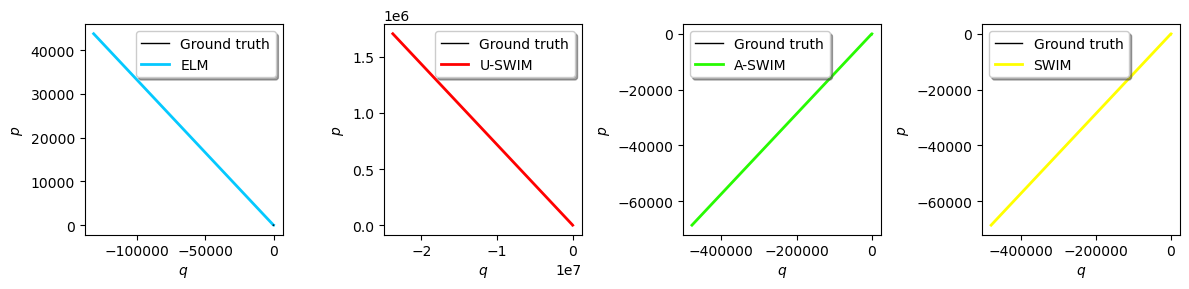

<Figure size 640x480 with 0 Axes>

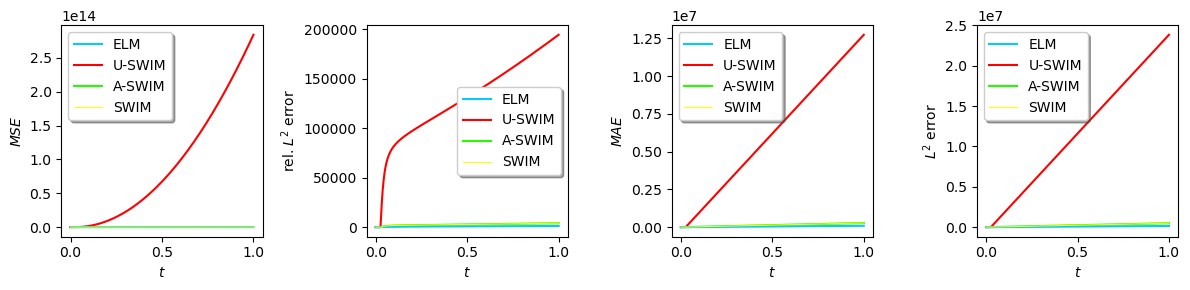

/home/gergedan/WS24/thesis/src/hamiltonians/lotka_volterra.py:18: RuntimeWarning: overflow encountered in power
  f = p - np.e**p + 2*q - np.e**q


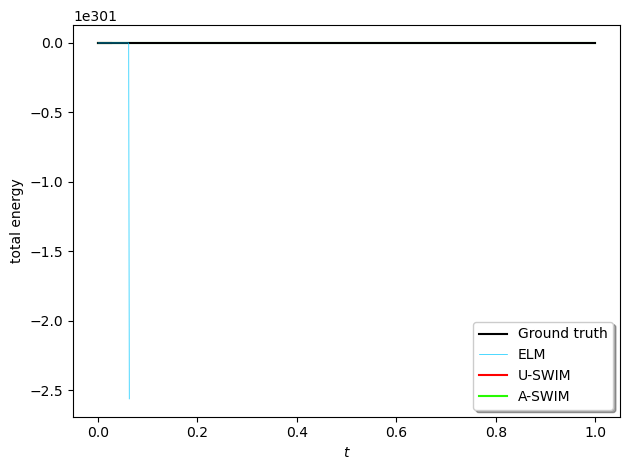

<Figure size 640x480 with 0 Axes>

In [10]:
# RK45
t_span = [0, 1]
t_eval = np.linspace(t_span[0], t_span[1], 1000)
y0 = [5, 5]

pendulum_motion_true = solve_ivp(dt_true, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-13)
pendulum_motion_pred_elm = solve_ivp(dt_pred_elm, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-13)
pendulum_motion_pred_uswim = solve_ivp(dt_pred_uswim, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-13)
pendulum_motion_pred_aswim = solve_ivp(dt_pred_aswim, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-13)
pendulum_motion_pred_swim = solve_ivp(dt_pred_swim, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-13)

# get integrated trajectories of shape (N,2)
traj_true = pendulum_motion_true.y.T
traj_pred_elm = pendulum_motion_pred_elm.y.T
traj_pred_uswim = pendulum_motion_pred_uswim.y.T
traj_pred_aswim = pendulum_motion_pred_aswim.y.T
traj_pred_swim = pendulum_motion_pred_swim.y.T

q_train_lim_start = experiment['domain_params']['q_train_lim'][0][0]
q_train_lim_end = experiment['domain_params']['q_train_lim'][0][1]
p_train_lim_start = experiment['domain_params']['p_train_lim'][0][0]
p_train_lim_end = experiment['domain_params']['p_train_lim'][0][1]
print(f"lim for q: [{q_train_lim_start}, {q_train_lim_end}]")
print(f"lim for p: [{p_train_lim_start}, {p_train_lim_end}]")
if np.any(traj_true[:,0] < q_train_lim_start):
    print(f"WARNING: q limit is out of bounds for this trajectory")
elif np.any(traj_true[:,0] > q_train_lim_end):
    print(f"WARNING: q limit is out of bounds for this trajectory")
    
if np.any(traj_true[:,0] < p_train_lim_start):
    print(f"WARNING: p limit is out of bounds for this trajectory")
elif np.any(traj_true[:,0] > p_train_lim_end):
    print(f"WARNING: p limit is out of bounds for this trajectory")
    
# plots colors
COLOR_TRUTH = '#000000'
COLOR_ELM = '#05c9ff' # blue
COLOR_USWIM = '#ff0000' # red
COLOR_ASWIM = '#28fa02' # green
COLOR_SWIM = '#ffff00' # yellow

# PREDICTIONS

fig = plt.figure(figsize=[12,3], dpi=100) # default resolution is 100
plt.subplot(1,4,1)
plt.plot(traj_true[:, 0], traj_true[:, 1], c=COLOR_TRUTH, label='Ground Truth', zorder=2, linewidth=1)
plt.plot(traj_pred_elm[:, 0], traj_pred_elm[:, 1], c=COLOR_ELM, label='ELM', zorder=1, linewidth=2)
plt.xlabel(r'$q$')
plt.ylabel(r'$p$')
plt.legend(['Ground truth', 'ELM'], shadow=True)
plt.subplot(1,4,2)
plt.plot(traj_true[:, 0], traj_true[:, 1], c=COLOR_TRUTH, label='Ground Truth', zorder=2, linewidth=1)
plt.plot(traj_pred_uswim[:, 0], traj_pred_uswim[:, 1], c=COLOR_USWIM, label='U-SWIM', zorder=1, linewidth=2)
plt.xlabel(r'$q$')
plt.ylabel(r'$p$')
plt.legend(['Ground truth', 'U-SWIM'], shadow=True)
plt.subplot(1,4,3)
plt.plot(traj_true[:, 0], traj_true[:, 1], c=COLOR_TRUTH, label='Ground Truth', zorder=2, linewidth=1)
plt.plot(traj_pred_aswim[:, 0], traj_pred_aswim[:, 1], c=COLOR_ASWIM, label='A-SWIM', zorder=1, linewidth=2)
plt.xlabel(r'$q$')
plt.ylabel(r'$p$')
plt.legend(['Ground truth', 'A-SWIM'], shadow=True)
plt.subplot(1,4,4)
plt.plot(traj_true[:, 0], traj_true[:, 1], c=COLOR_TRUTH, label='Ground Truth', zorder=2, linewidth=1)
plt.plot(traj_pred_swim[:, 0], traj_pred_swim[:, 1], c=COLOR_SWIM, label='SWIM', zorder=1, linewidth=2)
plt.xlabel(r'$q$')
plt.ylabel(r'$p$')
plt.legend(['Ground truth', 'SWIM'], shadow=True)
plt.tight_layout()
plt.show()
fig.savefig('./single_pendulum_trajectory_predictions.pdf')
plt.clf()

# ERRORS

mse_error_elm = [ mse.mean_squared_error(traj_true[i], traj_pred_elm[i]) for i in range(len(t_eval)) ]
mse_error_uswim = [ mse.mean_squared_error(traj_true[i], traj_pred_uswim[i]) for i in range(len(t_eval)) ]
mse_error_aswim = [ mse.mean_squared_error(traj_true[i], traj_pred_aswim[i]) for i in range(len(t_eval)) ]
mse_error_swim = [ mse.mean_squared_error(traj_true[i], traj_pred_swim[i]) for i in range(len(t_eval)) ]

l2_error_elm = [ l2_error.l2_error(traj_true[i], traj_pred_elm[i]) for i in range(len(t_eval)) ]
l2_error_uswim = [ l2_error.l2_error(traj_true[i], traj_pred_uswim[i]) for i in range(len(t_eval)) ]
l2_error_aswim = [ l2_error.l2_error(traj_true[i], traj_pred_aswim[i]) for i in range(len(t_eval)) ]
l2_error_swim = [ l2_error.l2_error(traj_true[i], traj_pred_swim[i]) for i in range(len(t_eval)) ]

mae_error_elm = [ mae.mean_absolute_error(traj_true[i], traj_pred_elm[i]) for i in range(len(t_eval)) ]
mae_error_uswim = [ mae.mean_absolute_error(traj_true[i], traj_pred_uswim[i]) for i in range(len(t_eval)) ]
mae_error_aswim = [ mae.mean_absolute_error(traj_true[i], traj_pred_aswim[i]) for i in range(len(t_eval)) ]
mae_error_swim = [ mae.mean_absolute_error(traj_true[i], traj_pred_swim[i]) for i in range(len(t_eval)) ]

rl2_error_elm = [l2_error_relative.l2_error_relative(traj_true[i], traj_pred_elm[i]) for i in range(len(t_eval)) ]
rl2_error_uswim = [l2_error_relative.l2_error_relative(traj_true[i], traj_pred_uswim[i]) for i in range(len(t_eval)) ]
rl2_error_aswim = [l2_error_relative.l2_error_relative(traj_true[i], traj_pred_aswim[i]) for i in range(len(t_eval)) ]
rl2_error_swim = [l2_error_relative.l2_error_relative(traj_true[i], traj_pred_swim[i]) for i in range(len(t_eval)) ]

fig = plt.figure(figsize=[12,3], dpi=100)
plt.subplot(1,4,1)
plt.plot(t_eval, mse_error_elm, c=COLOR_ELM, zorder=5)
plt.plot(t_eval, mse_error_uswim, c=COLOR_USWIM, zorder=4)
plt.plot(t_eval, mse_error_aswim, c=COLOR_ASWIM, zorder=3)
plt.plot(t_eval, mse_error_swim, c=COLOR_SWIM, zorder=8, linewidth=0.75) 
plt.xlabel(r'$t$')
plt.ylabel(r'$MSE$')
plt.legend(['ELM', 'U-SWIM', 'A-SWIM', 'SWIM'], shadow=True)
plt.subplot(1,4,2)
plt.plot(t_eval, rl2_error_elm, c=COLOR_ELM, zorder=5)
plt.plot(t_eval, rl2_error_uswim, c=COLOR_USWIM, zorder=4)
plt.plot(t_eval, rl2_error_aswim, c=COLOR_ASWIM, zorder=3)
plt.plot(t_eval, rl2_error_swim, c=COLOR_SWIM, zorder=8, linewidth=0.75) 
plt.xlabel(r'$t$')
plt.ylabel(r'rel. $L^2$ error')
plt.legend(['ELM', 'U-SWIM', 'A-SWIM', 'SWIM'], shadow=True)
plt.subplot(1,4,3)
plt.plot(t_eval, mae_error_elm, c=COLOR_ELM, zorder=5)
plt.plot(t_eval, mae_error_uswim, c=COLOR_USWIM, zorder=4)
plt.plot(t_eval, mae_error_aswim, c=COLOR_ASWIM, zorder=3)
plt.plot(t_eval, mae_error_swim, c=COLOR_SWIM, zorder=8, linewidth=0.75) 
plt.xlabel(r'$t$')
plt.ylabel(r'$MAE$')
plt.legend(['ELM', 'U-SWIM', 'A-SWIM', 'SWIM'], shadow=True)
plt.subplot(1,4,4)
plt.plot(t_eval, l2_error_elm, c=COLOR_ELM, zorder=5)
plt.plot(t_eval, l2_error_uswim, c=COLOR_USWIM, zorder=4)
plt.plot(t_eval, l2_error_aswim, c=COLOR_ASWIM, zorder=3)
plt.plot(t_eval, l2_error_swim, c=COLOR_SWIM, zorder=8, linewidth=0.75) 
plt.xlabel(r'$t$')
plt.ylabel(r'$L^2$ error')
plt.legend(['ELM', 'U-SWIM', 'A-SWIM', 'SWIM'], shadow=True)
plt.tight_layout()
plt.show()
fig.savefig('./single_pendulum_trajectory_errors.pdf')
plt.clf()

# total energy plots
energy_true = H(traj_true)
energy_pred_elm = H(traj_pred_elm)
energy_pred_uswim = H(traj_pred_uswim)
energy_pred_aswim = H(traj_pred_aswim)
energy_pred_swim = H(traj_pred_swim)
plt.plot(t_eval, energy_true, c=COLOR_TRUTH, zorder=12)
plt.plot(t_eval, energy_pred_elm, c=COLOR_ELM, zorder=14, linewidth=0.5)
plt.plot(t_eval, energy_pred_uswim, c=COLOR_USWIM, zorder=7)
plt.plot(t_eval, energy_pred_aswim, c=COLOR_ASWIM, zorder=8)
plt.plot(t_eval, energy_pred_swim, c=COLOR_SWIM, zorder=9, linewidth=0.5)
plt.xlabel('t')
plt.xlabel(r'$t$')
plt.ylabel('total energy')
plt.legend(['Ground truth', 'ELM', 'U-SWIM', 'A-SWIM'], shadow=True)
plt.tight_layout()
plt.show()
plt.savefig('./total_energies.pdf')
plt.clf()